# Disaster Tweets: Predicting Occurences of Real Disasters

Twitter has found use recently in many analytics problems as many people from around the world are able to report things before reputable news outlets can verify them. However, it is also the case that people lie or use language that implies a disaster in a metaphorical sense (eg. *we're going to cause an earthquake tonight*). The purpose of this Kaggle competition is to determine which bracket these tweets fall into based on their hand classified tweets.

In [1]:
import numpy as np
import pandas as pd
import sys
from sys import path
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

sys.path.append('./nlp-getting-started/')

## Importing the training tweets and getting to understand the dataset

Our dataset has $5$ columns:
 - Id: A unique identifier attached to the tweet.
 - keyword: A particular keyword from the tweet that might have been important or pertaining to a disaster (may be blank).
 - location: Location of the sender (may be blank).
 - text: The text contained in the tweet.
 - target: The class of the tweet. *Real Disaster* = $1$ and *False Alarm* = $0$
 
In the training set we have $7613$ tweets. 

There are $222$ unique keywords, including NaN. Examples of some keywords: *avalanche*, *damage*, *cyclone*, *siren* etc. 

There are $3342$ unique locations in the training set, these are city names such as *London*, *Birmingham*, *Vancouver, Canada* etc.
 

In [2]:
#Will split into training and test sets after
tweets = pd.read_csv('./nlp-getting-started/train.csv')
tweets.columns, len(tweets)

(Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object'), 7613)

In [3]:
#Importing the test tweets: these do not have a target label as they are for a kaggle competition
test_tweets = pd.read_csv('./nlp-getting-started/test.csv')

In [4]:
#Observing the dataframe structure
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
tweets['keyword'].unique();
tweets['location'].unique();

In [6]:
#Previewing some tweets
print('''This is a preview of the first 5 tweets all of which correspond to real disasters:
      ''')
for i in range(5):
    print(('%d. '+tweets['text'][i]) % i)

This is a preview of the first 5 tweets all of which correspond to real disasters:
      
0. Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1. Forest fire near La Ronge Sask. Canada
2. All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3. 13,000 people receive #wildfires evacuation orders in California 
4. Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


In [7]:
print('''This is a preview of the first 5 tweets all of which correspond to false alarms:
      ''')

counter = 1
for txt in tweets[tweets['target']==0]['text'][0:5]:
    print(('%d. '+txt) % counter)
    counter += 1


This is a preview of the first 5 tweets all of which correspond to false alarms:
      
1. What's up man?
2. I love fruits
3. Summer is lovely
4. My car is so fast
5. What a goooooooaaaaaal!!!!!!


### Observations about the text:

The text is likely to contain typos or misspellings as can be seen with the word *gooooooaaaaaaal*. The vocabulary we construct will be unlikely to contain such words due to their infrequency.

Tweeters often use # (hashtags) to indicate an important or relevant topic. This would likely be removed in standard tokenization, but it might be worth trying to retain the hashtag as they are words the tweeter wants to highlight. **Consider adding another column to the dataframe that only includes hashtags**

### Visualising occurences of keywords and locations

As we see, the most common word is *fatalities* with 45 counts (NaN excluded). The least used keyword is *radiation emergency* with 9 counts. However, for the keywords column the data has a very small gradient, with many keywords appearing a similar number of times.

The most frequent location of tweets are *USA* for country and *New York* for cities. Interestingly, *London* comes in at 2nd in the list of cities, but *UK* comes in 3rd place for countries.

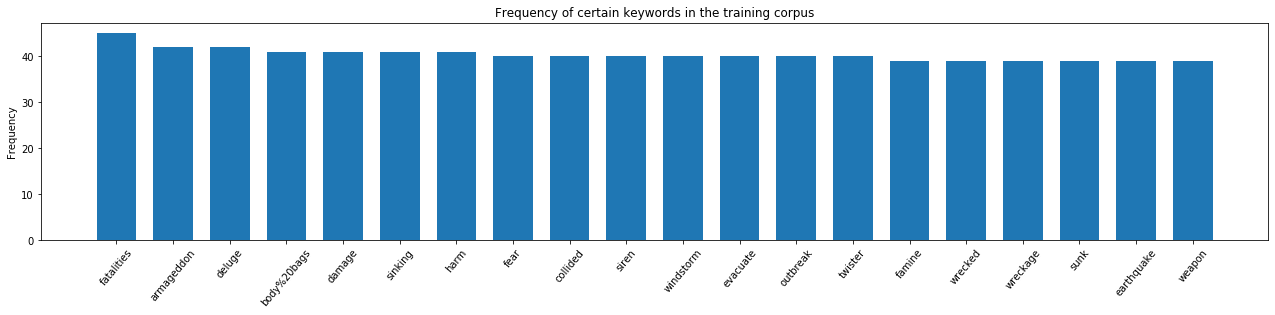

In [8]:
top_counts = [tweets['keyword'].value_counts()[i] for i in range(20)]
top_words = tweets['keyword'].value_counts().index.tolist()[0:20]

fig = plt.figure(figsize=(22,4))
plt.bar([i for i in range(20)],top_counts,width=0.7)
plt.xticks([i for i in range(20)],top_words,rotation=50)
plt.ylabel('Frequency')
plt.title('Frequency of certain keywords in the training corpus')
plt.show()

In [9]:
tweets['keyword'].value_counts()[0:2];
tweets['keyword'].value_counts()[220:221]


radiation%20emergency    9
Name: keyword, dtype: int64

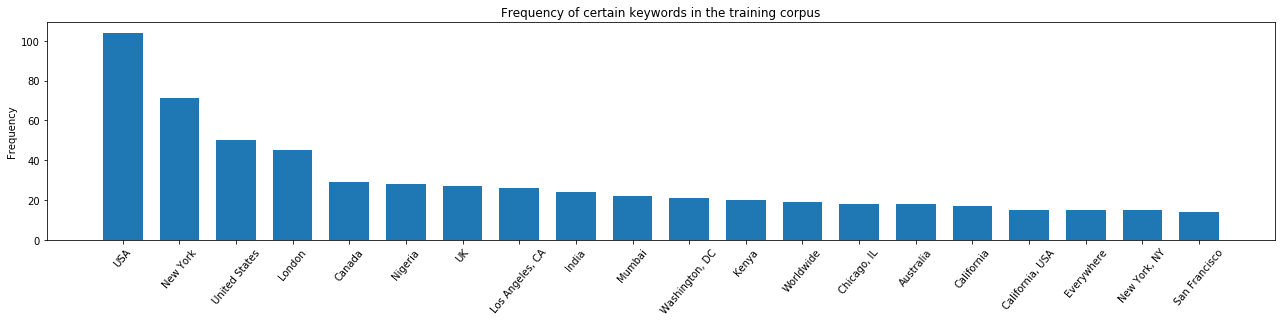

In [10]:
top_loc_counts = [tweets['location'].value_counts()[i] for i in range(20)]
top_locs = tweets['location'].value_counts().index.tolist()[0:20]

fig = plt.figure(figsize=(22,4))
plt.bar([i for i in range(20)],top_loc_counts,width=0.7)
plt.xticks([i for i in range(20)],top_locs,rotation=50)
plt.ylabel('Frequency')
plt.title('Frequency of certain keywords in the training corpus')
plt.show()

## Cleaning the text data using the Regular Expressions (re) library and strings


In [11]:
import re

def clean_tweet(text):
    # encode tweets as utf-8 strings
#     text = text.decode('utf-8')
    # remove commas in numbers (else vectorizer will split on them)
    text = re.sub(r',([0-9])', '\\1', text)
    # sort out HMTL formatting of &
    text = re.sub(r'&amp', 'and', text)
    # strip urls
    return re.sub(r'http[s]{0,1}://[^\s]*', '', text)

tweets['text'] = tweets['text'].map(clean_tweet)

In [12]:
#temporary whitelist before using the re library, returns tweets with only the permitted characters and lowercase
import string

def whitelisted(text):
    whitelist = string.ascii_letters + string.digits + ' ' + '\'' + '.'
    new_s = ''
    for char in text:
        if char in whitelist:
            new_s += char
        else:
            new_s += ' '
    
    return new_s.lower()

tweets['text'] = tweets['text'].map(whitelisted)


#Removing twitter handles from text - not implemented yet
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)


## Basic word analysis

Questions to answer: How many words on average does a tweet have, What are the most common words, What is the word distribution for the 100 most common words, Word Cloud?

Importantly, we should also know how these keywords correlate with the target label. For example, is the word 'blast' found more often in non-emergency tweets than emergency tweets? What we would find from this is the class imbalance. If a word was involved in a disaster 80% of the time, then a basic model could get a high recall by always associating that word with a disaster target label. However, as it would throw up a lot of false positives, it would have low precision.

There are 222 keywords, including NaN, so we will only plot the top and bottom 20 ratios, as well as those middling ones.

In [13]:
#Analysing class imbalance for all relevant keywords

keywords = tweets['keyword'].unique()
keyword_target_fraction = {keyword: (tweets[tweets['keyword']== keyword]['target'].sum()/len(tweets[tweets['keyword']== keyword])) for keyword in keywords}
keyword_target_fraction;

#Need to sort the keyword_target_fraction dictionary by ratio. 
keyword_target_fraction_list = [[k, v] for (k,v) in keyword_target_fraction.items()]

keyword_target_fraction_list.sort(key=lambda x: x[1])

#remove the NaN row
key_target_fractions = keyword_target_fraction_list[1:]

#showing the list
key_target_fractions;

/Users/eh115/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


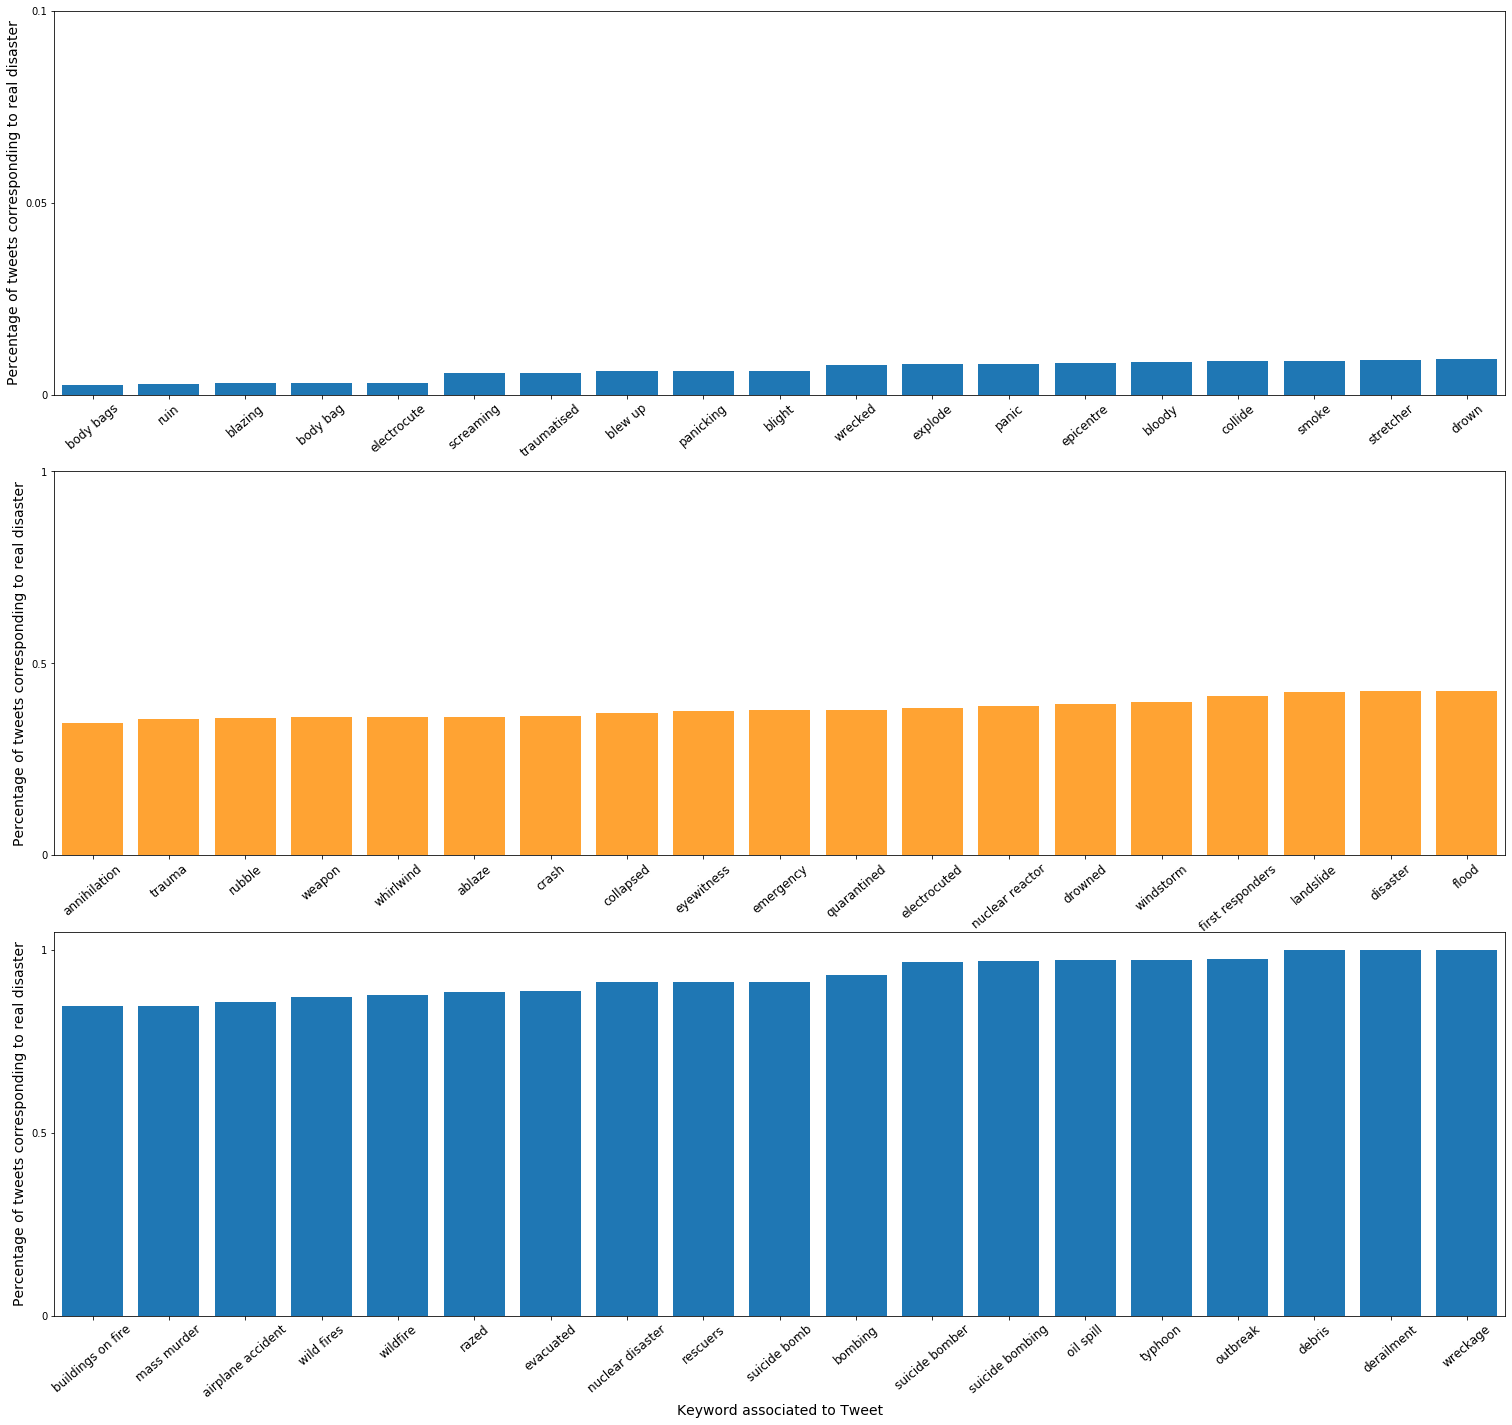

In [14]:
#Plotting the fraction of real disasters for each keyword
bottom_20 = np.array(key_target_fractions)[:,1:][0:20].flatten().astype(float)
top_20 = np.array(key_target_fractions)[:,1:][-20:].flatten().astype(float)
middle_20 = np.array(key_target_fractions)[:,1:][100:120].flatten().astype(float)

#Some names need to be cleaned due to formatting
bottom_20_names = np.array(key_target_fractions)[:,0:1][0:20].flatten()
bottom_20_names = [name.replace('%20',' ') for name in bottom_20_names]

top_20_names =  np.array(key_target_fractions)[:,0:1][-20:].flatten()
top_20_names = [name.replace('%20',' ') for name in top_20_names]

middle_20_names =  np.array(key_target_fractions)[:,0:1][100:120].flatten()
middle_20_names = [name.replace('%20',' ') for name in middle_20_names]


fig, ax = plt.subplots(figsize=(26,24), nrows = 3)

ax[0].bar([i for i in range(20)],bottom_20)
ax[0].set_xticks([i for i in range(20)])
ax[0].set_xticklabels(bottom_20_names,rotation=40,fontsize=12)
ax[0].set_yticks([0,0.5,1])
ax[0].set_yticklabels([0,0.05,0.1])
ax[0].set_ylabel('Percentage of tweets corresponding to real disaster',fontsize = 14)
#ax[0].set_xlabel('Keyword associated to Tweet',fontsize = 14)
ax[0].set_xlim([0.5,19.5])

ax[2].bar([i for i in range(20)],top_20)
ax[2].set_xticks([i for i in range(20)])
ax[2].set_xticklabels(top_20_names,rotation=40,fontsize=12)
ax[2].set_yticks([0,0.5,1])
ax[2].set_yticklabels([0,0.5,1])
ax[2].set_ylabel('Percentage of tweets corresponding to real disaster',fontsize = 14)
ax[2].set_xlabel('Keyword associated to Tweet',fontsize = 14)
ax[2].set_xlim([0.5,19.5])

ax[1].bar([i for i in range(20)],middle_20,alpha=0.8,color='darkorange')
ax[1].set_xticks([i for i in range(20)])
ax[1].set_xticklabels(middle_20_names,rotation=40,fontsize=12)
ax[1].set_yticks([0,0.5,1])
ax[1].set_yticklabels([0,0.5,1])
ax[1].set_ylabel('Percentage of tweets corresponding to real disaster',fontsize = 14)
#ax[1].set_xlabel('Keyword associated to Tweet',fontsize = 14)
ax[1].set_xlim([0.5,19.5])
plt.show()

In [15]:
#Plot the tweet length distribution

**Observations**

- There are a few surprises hidden here. For example, most uses of the phrase 'body bag' do not correspond to an instance of a disaster. This is quite odd, as the other words in the bottom 20 can at least be used in other examples. My experience suggests it is rare to see body bags outside of a disaster setting.

- All phrases in the top 20 suggest real disasters and are therefore heavily imbalanced. Interestingly, typhoon has a very strong correlation with a real disaster, whereas the closely related word whirlwind, seemingly has a much smaller association with disasters.

Lets peer into these examples some more.

In [16]:
#Printing 10 tweets associated to the body bags keyword

def tweets_for_keyword(n_tweets,keyword):
    """
    n_tweets: int, number of tweets to be printed
    keyword: string, must be a string from the tweets dataframe
    """
    count = n_tweets
    for tweet in tweets['text'][tweets['keyword'] == keyword]:
        print(tweet + '\n')
        count += -1
        if count < 0:
            break

tweets_for_keyword(10,'body%20bags')

 foxnews  jengriffinfnc when you call to report dangerous activity tell em to have body bags on arrival.

micom 2015 summer contrast candy color bowknot cross body tote shoulder bags for womengirls with micom zip po 

hobo hobo vintage shira convertible b     238.00  bestseller 

child shoulder bags pvc shoulder book bag cartoon cross body bags for girls  

womens buckle casual stylish shoulder handbags pockets cross body bags green 

ain't no bags in the trunk it's a body

bestseller  fossil dawson mini cross body bag es     98.00 

 boomerangtime  rskarim1  sopameer  wattashit3 appears to already be arriving in ridah in body bags.

the body bags has a show on 08 07 2015 at 07 30 pm   tremont music hall in charlotte nc   concert

body bags  

you know you hate your body when you buy 2 bags of chips and a variety pack of fruit snacks and a redbull as a snack



**Observation**

What we see is that many instances of the words 'body' and 'bag' appearing together, are often to do with fashion or the words are separated.

### Further cleaning the data

As we can see in some of the prior examples, dates as well as prices appear. We will remove dates and prices, though an interesting thing to look at would be the appearance of prices in tweets and their target label. I suspect no prices appear in real disaster tweets, which would remove many cases.

In [17]:
# Make every tweet lower case and create a list of keyword tweet pairs
kw_twt_pairs = []
count = 0
for tweet in tweets['text'].str.lower():
    kw_twt_pairs.append([tweets['keyword'][count],tweet])
    count += 1


kw_twt_pairs[252][1]

' kimkardashian can you please sign and share this petition to save wild horses in arizona.      '

In [18]:
tweet_list = [tweet for tweet in tweets['text']]

### Word tokenization, lemmatization, removal of stop words and part of speech tagging

Need to remove unwanted punctuation

In [19]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def tokenizer(df,):
    """
    df: pandas dataframe. Data type must be string format.
    """
    tokenized_list = []
    for text in df:
        tokenized_list.append(word_tokenize(text))
    
    return tokenized_list



[nltk_data] Downloading package punkt to /Users/eh115/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
#The sentences are now tokenized
kw_twt_pairs[500]

['attacked',
 'christian attacked by muslims at the temple mount after waving israeli flag via pamela geller   ... ']

In [21]:
#pos tagging to be able to put words in their root form
# from nltk import pos_tag
# nltk.download('averaged_perceptron_tagger')

In [22]:
# count = 0
# for block in kw_twt_pairs:
#     kw_twt_pairs[count][1] = pos_tag(kw_twt_pairs[count][1])
#     count += 1


In [23]:
#Lemmatizing the words to reduce to root form
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/eh115/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
# lemmatizer = WordNetLemmatizer()

# count = 0
# word_count = 0
# for block in kw_twt_pairs:
#     for tokenized_word in block[1]:
#         word_pos = block[1][word_count][1]
#         kw_twt_pairs[count][1][word_count] == (lemmatizer.lemmatize(block[1][word_count][0], pos=word_pos), word_pos)
#         word_count += 1
#     word_count = 0
#     count += 1


## Creating a Naive Bayes Multinomial Model

Note: I will first create a model with non-completely clean text. This will decrease the performance of the model. However, I will then go back and clean the text data which should improve the model.

In [25]:
#tweets corresponding to disasters and convert to nested list
disaster_tweets = tweets[['text','target']][tweets['target'] == 1]

#The CountVectorizer transform takes in raw text and therefore doesn't need to be tokenized
disaster_list = [tweet for tweet in disaster_tweets['text']]
disaster_tokenized = tokenizer(disaster_tweets['text'])
num_dis = len(disaster_tweets)


#tweets not corresponding to disasters and convert to nested list
non_disaster_tweets = tweets[['text','target']][tweets['target'] == 0]
non_disaster_list =[tweet for tweet in non_disaster_tweets['text']]
non_disaster_tokenized = tokenizer(non_disaster_tweets['text'])
num_non_dis = len(non_disaster_tweets)

#Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tweets['text'], tweets['target'], test_size=0.2, random_state=42)

#Splitting the disaster and non_disaster lists of tweets separately
d_train, d_val, yd_train, yd_val = train_test_split(disaster_tokenized, ([1] * num_dis), test_size = 0.2, random_state = 42)

nd_train, nd_val, ynd_train, ynd_val = train_test_split(non_disaster_tokenized, ([0] * num_non_dis), test_size = 0.2, random_state = 42)



In [26]:
#Create an instance of the CountVectorizer
counter = CountVectorizer()

#flattened list of training vocabulary
training_vocab = [item for sublist in (d_train+nd_train) for item in sublist]

#create a vocabulary from the training set
counter.fit(training_vocab)

#transform the training data
training_counts = counter.transform(X_train)
validation_counts = counter.transform(X_val)

#Create an instance of a MultinomialNB classifier
nb_classifier = MultinomialNB()

#fit the classifier to the training data
nb_classifier.fit(training_counts,y_train)

#Score on the validation set
score = nb_classifier.score(validation_counts,y_val)
print('On the validation set, the Naive Bayes classifier achieves an accuracy of %.2f percent' % (score * 100))


On the validation set, the Naive Bayes classifier achieves an accuracy of 79.78 percent


### Our first attempt got a validation accuracy of 79.78%

I will go back and clean the data better, and also make bigram and trigram models. However, it will be interesting to create a few examples and see what the classifier predicts.

In [27]:
def classify_text(text):
    text_counts = counter.transform([text]).toarray()
    prediction_probabilities = nb_classifier.predict_proba(text_counts)[0]
    classes = ['not a disaster', 'disaster']
    
    if prediction_probabilities[0] > prediction_probabilities[1]:
        classification = classes[0]
    else:
        classification = classes[1]
    
    print("""Probability it's not a disaster: %.2f \nProbability it's a disaster: %.2f. \nClassification: %s
    """ % (prediction_probabilities[0],prediction_probabilities[1],classification) )
    
    

In [28]:
classify_text('no deaths in peacetime')

Probability it's not a disaster: 0.09 
Probability it's a disaster: 0.91. 
Classification: disaster
    


In [33]:
from N_gram import n_gram

n_gram_tweets = n_gram(tweets['text'],3)
n_gram_tweets

[['our deeds are',
  'deeds are the',
  'are the reason',
  'the reason of',
  'reason of this',
  'of this earthquake',
  'this earthquake may',
  'earthquake may allah',
  'may allah forgive',
  'allah forgive us',
  'forgive us all'],
 ['forest fire near',
  'fire near la',
  'near la ronge',
  'la ronge sask',
  'ronge sask .',
  'sask . canada'],
 ['all residents asked',
  'residents asked to',
  "asked to 'shelter",
  "to 'shelter in",
  "'shelter in place",
  "in place '",
  "place ' are",
  "' are being",
  'are being notified',
  'being notified by',
  'notified by officers',
  'by officers .',
  'officers . no',
  '. no other',
  'no other evacuation',
  'other evacuation or',
  'evacuation or shelter',
  'or shelter in',
  'shelter in place',
  'in place orders',
  'place orders are',
  'orders are expected'],
 ['13000 people receive',
  'people receive wildfires',
  'receive wildfires evacuation',
  'wildfires evacuation orders',
  'evacuation orders in',
  'orders in calif